In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import radians, degrees, cos, sin, asin, sqrt

from scipy.stats import hmean

# from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm_t

from tqdm._tqdm_notebook import tqdm_notebook as tqdm

import feather

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout

from pathlib import Path

import utm

from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import nearest_points

from multiprocessing import Pool

from matplotlib.colors import LogNorm

from sklearn.neighbors import KNeighborsRegressor

from sklearn.decomposition import PCA

In [2]:
test_fraction = 4/5

In [3]:
messages = pd.read_csv("../../Trapeze_Data/first dump/VehicleMessages.csv", dtype={"isValid":float, "workCode":float,"tripCode":float}, parse_dates=[1], infer_datetime_format=True)


In [4]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "mean_durations_by_segment_code_and_hour",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival',
                                     'publicName',
                                     'segment_name',
                                     'prev_segment_code_1',
                                     'next_segment_code_1'
                                    ])
se = se.set_index(se.columns[0])

In [70]:
se['segment_duration'].mean()

46.03960549855144

In [5]:
routes = pd.read_csv("../../Bournemouth GTFS/routes.csv")
shapes = pd.read_csv("../../Bournemouth GTFS/shapes.csv")
stops = pd.read_csv("../../Bournemouth GTFS/stops.txt").set_index('stop_id')
trips = pd.read_csv("../../Bournemouth GTFS/trips.txt")
performed_work = pd.read_csv("../../Trapeze_Data/first dump/PerformedWork.csv", parse_dates=[1])

In [6]:
# se['speed_mph'] = se['line_distance']*1000/se['segment_duration'] * 2.237

# se['speed_mph_baseline'] = se['line_distance']*1000/se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

# And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

In [7]:
se['prev_segment_name'] = se['prev_segment_code_1'].str[:-2]
se['next_segment_name'] = se['next_segment_code_1'].str[:-2]

In [8]:
trips_to_shapes_dict = {}

for route_id, route_group in trips.groupby('route_id'):
    matching_shapes = route_group.groupby('shape_id').first().index.values
    
    trips_to_shapes_dict[route_id] = matching_shapes


In [9]:
shapes_dict = {}

for shape_name, shape in tqdm(shapes.groupby('shape_id')):
    
    coords = np.empty((len(shape)+1, 2))
    
    for i, row in enumerate(shape[['latitude','longitude']].itertuples()):

        coords[i, :] = utm.from_latlon(row[1], row[2])[:2]
                        
    shapes_dict[shape_name] = LineString(coords)

          

In [10]:
segment_cache = {}

def find_length_by_name_route(segment_name, route_id, line_dist):
    
    line_dist = line_dist * 1000
    
    if segment_name in segment_cache:
        return segment_cache[segment_name]
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            segment_cache[segment_name] = line_dist
            
            return line_dist
    
    best_dist = np.inf
    lengths = []
    distances = []
    
    stop_codes = segment_name.split('_')

    try:
        stop_1_point = Point(utm.from_latlon(*stops.loc[stop_codes[0]][['stop_lat', 'stop_lon']].values)[:2])

        stop_2_point = Point(utm.from_latlon(*stops.loc[stop_codes[1]][['stop_lat', 'stop_lon']].values)[:2])
    except KeyError:
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    for shape_name in trips_to_shapes_dict[route_id]:

        shape = shapes_dict[shape_name]
        
        nearest_1 = nearest_points(shape, stop_1_point)[0]
        nearest_2 = nearest_points(shape, stop_2_point)[0]

        combined_dist = stop_1_point.distance(nearest_1) + stop_2_point.distance(nearest_2)
            
#         distances.append(combined_dist)
#         lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))

        # Find the cases where the points are close to the shape
        if (combined_dist) <= best_dist:
            best_dist = combined_dist
            
            distances.append(combined_dist)
            lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))
                
    if(best_dist >= 15):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    # Take the mean of only those shapes where the points is very close to the shape
    new_length = np.mean(np.asarray(lengths)[np.asarray(distances) == best_dist])
    
    if (new_length == 0) | (new_length > 4000):
        
        segment_cache[segment_name] = line_dist
        
        return line_dist

    segment_cache[segment_name] = new_length

    return segment_cache[segment_name]

In [11]:
def find_length_by_geo_route(lat1, lon1, lat2, lon2, route_id, line_dist):
    
    # Try if line_dist < 20 just return line_dist...
    
    if line_dist == 0:
        return line_dist
    
    if type(route_id) == float:
        if np.isnan(route_id):
            
            return line_dist
    
    best_dist = np.inf
    lengths = []
    distances = []

    try: 
        stop_1_point = Point(utm.from_latlon(lat1, lon1)[:2])

        stop_2_point = Point(utm.from_latlon(lat2, lon2)[:2])
        
        shape_names = trips_to_shapes_dict[route_id]
        
        lengths = np.empty(len(shape_names))
        distances = np.empty(len(shape_names))
    
        for idx, shape_name in enumerate(shape_names):

            shape = shapes_dict[shape_name]

            nearest_1 = nearest_points(shape, stop_1_point)[0]
            nearest_2 = nearest_points(shape, stop_2_point)[0]
            
            distances[idx] = stop_1_point.distance(nearest_1) + stop_2_point.distance(nearest_2)
            lengths[idx] = np.abs(shape.project(nearest_1) - shape.project(nearest_2))
            
#             # Find the cases where the points are close to the shape
#             if (combined_dist) <= best_dist:
#                 best_dist = combined_dist
                
#                 distances.append(combined_dist)
#                 lengths.append(np.abs(shape.project(nearest_1) - shape.project(nearest_2)))

        best_dist = np.min(distances)
   
        # If the combined distance between the points and the best shape is over 10 meters
        # Or if the distance is more than a quater of the strieght line distance between the 
        # points just use the line distance.
        if (best_dist >= 10) or ((best_dist * 4) > line_dist):
            return line_dist

        # Take the mean of only those shapes where the points is very close to the shape
        new_length = np.mean(lengths[distances == best_dist])

    except: 
        return line_dist
    
    if (new_length == 0) | (new_length > line_dist*5) | (new_length < line_dist):
        
        return line_dist

    return new_length

In [12]:
se['route_id'] = routes.set_index('route_short_name').loc[se['publicName']]['route_id'].values


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [13]:
tqdm.pandas("My Bar")

In [14]:
se['real_length'] = se.progress_apply(lambda row: find_length_by_name_route(row['segment_name'], row['route_id'], row['line_distance']), axis=1)

In [15]:
se['speed_mph'] = se['real_length'] / se['segment_duration'] * 2.237

se['speed_mph_baseline'] = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

In [ ]:
messages['timeReported'] = pd.to_datetime(messages['timeReported'])

In [ ]:
messages['delta_time'] = messages['timeReported'] - messages.shift(1)['timeReported']
messages['time_seconds'] = messages['delta_time'] / np.timedelta64(1, 's')

In [ ]:
messages['workCode'] = messages['workCode'].fillna(method="ffill")
messages['tripCode'] = messages['tripCode'].fillna(method="ffill")

In [ ]:
messages['dateReported'] = messages['timeReported'].dt.date

In [ ]:
messages['dateReported'] = pd.to_datetime(messages['dateReported'])

In [ ]:
performed_work['tripCode'] = performed_work['tripCode'].replace([np.nan, np.inf], -1)

performed_work['tripCode'] = performed_work['tripCode'].astype(int)

In [ ]:
messages = messages.reset_index().merge(performed_work[['workCode', 'tripCode', 'date', 'publicName']],
                            left_on=['workCode', 'tripCode', 'dateReported'], 
                            right_on=['workCode', 'tripCode', 'date'],
                           how="left").set_index("index")

In [ ]:
messages = messages.drop(columns=['date_x', 'publicName_x'])

In [ ]:
messages = messages.reset_index().merge(routes[['route_short_name', 'route_id']], 
                                        left_on=['publicName'], 
                                        right_on=['route_short_name'], 
                                        how="left").set_index("index")

In [ ]:
plt.hist((messages['delta_time'] / np.timedelta64(1, 's')).values, bins=100, range=(-10, 300));
plt.yscale("log")
plt.show()

In [ ]:
print(f"Fraction under 31 seconds: {np.count_nonzero(messages['time_seconds'] < 31)/messages.shape[0]}")
      
print(f"Between 20 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 20))/messages.shape[0]}")
      
print(f"Between 10 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 10))/messages.shape[0]}")
      
print(f"Between 5 and 31 seconds: {np.count_nonzero((messages['time_seconds'] < 31) & (messages['time_seconds'] > 5))/messages.shape[0]}")
      

In [ ]:
messages['delta_lon'] = messages['lon'] - messages.shift(1)['lon']
messages['delta_lat'] = messages['lat'] - messages.shift(1)['lat']

In [ ]:
messages['msg'].unique()

In [ ]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [ ]:
messages['delta_distance'] = haversine_np(messages['lon'], messages['lat'], messages['lon'].shift(1), messages['lat'].shift(1)) * 1000


In [ ]:
messages = messages.dropna(subset=['lon', 'lat'])

messages = messages[(messages['time_seconds'] > 0)]

In [ ]:
messages['lon_next'] = messages['lon'].shift(1)
messages['lat_next'] = messages['lat'].shift(1)


In [ ]:
num_partitions = 20
num_cores = 5

def parallelize_dataframe(df, func, args):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    
    # This line is fidly, we make a list where each item is a tuple of 
    # a bit of the dataframe and whatever is passed in as args. 
    # Then starmap unpacks that tuple so each copy of func gets it's 
    # little bit of the dataframe and the right args to do it's job. 
    # All this to avoid globals! 
    all_args = [(split,) + args for split in df_split]
    
    df = pd.concat(pool.starmap(func, all_args))
    pool.close()
    pool.join()
    return df

In [ ]:
messages.iloc[1510485]


In [ ]:
def find_dist(messages):

    messages['true_distance'] = messages[['lon', 'lat', 
                                          'lon_next', 'lat_next', 
                                          'route_id', 'delta_distance'
                                         ]].apply(lambda row: find_length_by_geo_route(*row[['lat', 'lon',
                                                                                          'lat_next', 
                                                                                           'lon_next',
                                                                                           'route_id',
                                                                                           'delta_distance'
                                                                                          ]]), axis=1)

    return messages



In [ ]:
messages = parallelize_dataframe(messages, find_dist, ())

In [ ]:
messages['delta_speed'] = messages['true_distance']/messages['time_seconds']

In [ ]:
messages['speed_mph'] = messages['delta_speed'] * 2.237

In [ ]:
# messages.to_csv("messages_with_true_dist.csv")

messages = pd.read_csv("messages_with_true_dist.csv")

In [ ]:
messages.to_csv("messages_with_true_dist.csv")

In [ ]:
print(f"total: {len(messages)}")

print(f"changed: {np.count_nonzero(messages['true_distance'] != messages['delta_distance'])}")
      
print(f"is close: {np.count_nonzero(np.isclose(messages['true_distance'], messages['delta_distance']))}")

In [ ]:
plt.hist2d(messages['delta_distance'], messages['true_distance'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("straight line distance")
plt.ylabel("real distance")
plt.colorbar()

In [ ]:
(np.count_nonzero(messages['delta_distance'] == messages['true_distance'])/len(messages))*100

In [ ]:
print(f"total: {len(se)}")

print(f"changed: {np.count_nonzero(se['real_length'] != se['line_distance']*1000)}")
      
print(f"is close: {np.count_nonzero(np.isclose(se['real_length'], se['line_distance']*1000))}")

plt.hist2d(se['line_distance']*1000, se['real_length'], bins=[50,50], range=[[0,800],[0,800]], norm=LogNorm())
plt.axis('equal')
plt.xlabel("straight line distance")
plt.ylabel("real distance")
plt.colorbar()

In [ ]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

In [ ]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400));
plt.yscale("log")

In [ ]:
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5)]['speed_mph'], bins=100, range=(-10,400), label="5");
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 10)]['speed_mph'], bins=100, range=(-10,400), label="10", alpha=0.5);
plt.hist(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 20)]['speed_mph'], bins=100, range=(-10,400), label="20", alpha=0.5);
plt.yscale("log")
plt.legend()

In [ ]:
np.sum(messages[(messages['msg'].isin(['inPosition', 'InPointArrive']))]['time_seconds'])

In [ ]:
np.sum(messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['speed_mph'] < 3)]['time_seconds'])

In [ ]:
226289342.0/431833852.0*100

In [ ]:
messages['prev_speed_mph'] = messages.shift(1)['speed_mph']
messages['next_speed_mph'] = messages.shift(-1)['speed_mph']

In [ ]:
messages['jitter'] = [False]*messages.shape[0]

messages['jitter'] = (messages['speed_mph'] > 75) & \
    (((messages['prev_speed_mph'] > 75) & (messages['next_speed_mph'] < 50)) | \
     ((messages['next_speed_mph'] > 75) & (messages['prev_speed_mph'] < 50)))

In [ ]:
filtered = messages[(messages['msg'].isin(['inPosition', 'InPointArrive'])) & (messages['time_seconds'] < 31) & (messages['time_seconds'] > 5) & (messages['jitter'] == False) & (messages['speed_mph'] != np.inf)]


In [ ]:
plt.hist(filtered['speed_mph'], bins=100, range=(0,75));
plt.yscale("log")

In [ ]:
hourly_averages = filtered.groupby(filtered['timeReported'].dt.hour).mean()

In [ ]:
plt.scatter(hourly_averages.index, hourly_averages['speed_mph'])

In [ ]:
filtered['segment_name'] = filtered['stopCode'].fillna(method="ffill") + "_" + filtered['stopCode'].fillna(method="bfill") 

In [ ]:
se['speed_mph'] = se['real_length']/se['segment_duration'] * 2.237

In [ ]:
plt.hist(se['speed_mph'], range=(0, 60), bins=61);

In [16]:
se['mean_speed_mph_by_segment_code'] = se['real_length']/se['mean_durations_by_segment_code'] * 2.237

se['mean_speed_mph_by_segment_code_hour'] = se['real_length']/se['mean_durations_by_segment_code_and_hour'] * 2.237

se['speed_mph_diff_mean_to_hour'] = se['mean_speed_mph_by_segment_code_hour'] - se['mean_speed_mph_by_segment_code']


In [ ]:
just_one = se[se['arrival_day'] < 5].groupby(["segment_name", "arrival_hour"]).first()

In [ ]:
just_one = just_one.reset_index().merge(all_stats_df, left_on=['segment_name','arrival_hour'], right_on=['seg_name','hours']) # .set_index(['segment_name','arrival_hour'])

just_one = just_one.dropna(axis=0)

In [ ]:
data_to_fit = just_one[['slow_fraction', 'fast_mean', 'total_mean',
                        'clipped_hmean','clipped_mean','freq',
                        'fast_hmean', 'real_length', ]].values
#                         'direction_degrees', 'to_centre_dist']].values

poly = PolynomialFeatures(2)

expanded_data = poly.fit_transform(data_to_fit)

names = poly.get_feature_names(['slow_fraction', 'fast_mean', 'total_mean',
                                'clipped_hmean','clipped_mean','freq',
                                'fast_hmean','real_length', ])
                                #'direction_degrees', 'to_centre_dist'])


In [20]:
def prep_training_data(data, target, cut_point):

#     cut_point = int(len(data)*test_fraction)
    
    train_data = data[:cut_point,:]
    test_data = data[cut_point:,:]
    
    test_mask = np.zeros(data.shape[0]).astype(bool)
    test_mask[cut_point:] = True

    train_target = target[:cut_point]
    test_target = target[cut_point:]
    
    scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

#     scaler_target = preprocessing.MinMaxScaler().fit(train_target[:, None])


    train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
    test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)
    
    data_scaler = preprocessing.StandardScaler()

    train_data_scaled = data_scaler.fit_transform(train_data).squeeze()
    test_data_scaled = data_scaler.transform(test_data).squeeze()

    return train_data_scaled, test_data_scaled, train_target_scaled, test_target_scaled, scaler_target


In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values, int(len(expanded_data)*test_fraction))

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

lr = LinearRegression()
# lr = Lasso()

lr.fit(train_data_scaled, train_target_scaled)

test_y_scaled = lr.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


In [ ]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

ordered_coef = np.array(lr.coef_).squeeze()[np.argsort(np.abs(lr.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(expanded_data, just_one['mean_speed_mph_by_segment_code_hour'].values, int(len(expanded_data)*test_fraction))

ar = ARDRegression()
# lr = Lasso()

ar.fit(train_data_scaled, train_target_scaled)

test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))


In [ ]:
test_y_scaled = ar.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

test_target_truth = scaler_target.inverse_transform(test_target_scaled)

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)


In [ ]:
ordered_names = np.array(names).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

ordered_coef = np.array(ar.coef_).squeeze()[np.argsort(np.abs(ar.coef_))].squeeze()

display(list(zip(ordered_names, ordered_coef))[::-1])

In [40]:
def create_simple_model(input_shape, dropout, NN, use_linear):

    # with help from: https://keras.io/getting-started/functional-api-guide/

    # Headline input: meant to receive road time series.
    main_input = Input(shape=[input_shape], dtype="float32", name="input")

    for index, layer in enumerate(NN):
        if(index == 0):
            x = Dense(layer, activation="relu")(main_input)
            x = Dropout(rate=dropout)(x)
        else:
            x = Dense(layer, activation="relu")(x)
            x = Dropout(rate=dropout)(x)

#     # We stack a deep densely-connected network on top
#     x = Dense(128, activation="relu")(main_input)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(64, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(32, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)
#     x = Dense(12, activation="relu")(x)
#     x = Dropout(rate=dropout)(x)

    # And finally we add the main output layer
    if use_linear:
        main_output = Dense(1, activation="linear", name="main_output")(x)
    else: 
        main_output = Dense(1, activation="tanh", name="main_output")(x)

    model = Model(
        inputs=[main_input], outputs=[main_output]
    )

    model.summary()

    return model

In [ ]:
(train_data_scaled, test_data_scaled, 
 train_target_scaled, test_target_scaled, 
 scaler_target) = prep_training_data(data_to_fit, just_one['mean_speed_mph_by_segment_code_hour'], int(len(data_to_fit)*test_fraction))

model = create_simple_model(
        (train_data_scaled.shape[1]),
        0.1)

Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"GPS_models/simple.h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="mse")
model.fit(
    train_data_scaled,
    train_target_scaled,
    epochs=100,
    callbacks=callbacks_list,
    batch_size=32,
    validation_data=(test_data_scaled, test_target_scaled),
)

test_y_scaled = model.predict(test_data_scaled)

test_y = scaler_target.inverse_transform(test_y_scaled)

In [ ]:
test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.scatter(test_target_truth, test_y, marker=".", alpha=0.3)
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)

### Plan

- Calc the stats for all the segments
- Load up the means by hour of the day and daytype for each of these segment names
- Try to find a way to predict the spead of the segment by hour using the stats
- Get the stats for each indivual event, not just the bulk averages, 
    - Do the same for the last hour on that segment and think about fast ways to do prev/next as well
- Try to find the stats with the highest and lowest variance (forcus on those with lower variance)
- See if you can then find outliers... 
- Is there enough data? 

In [19]:
segments_dict = {}

segments = filtered.groupby('segment_name')

for seg_name, segment in segments:
    
     df = segment.set_index("timeReported")['speed_mph']
        
     df.index = pd.to_datetime(df.index)
    
     segments_dict[seg_name] = df

NameError: name 'filtered' is not defined

In [ ]:
matrix_width = 16

In [ ]:
se_gps_data_hour = np.zeros((se.shape[0], matrix_width)).astype(np.float32)
se_gps_data_20mins = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [ ]:
se_gps_data_hour_prev_next = np.zeros((se.shape[0], matrix_width)).astype(np.float32)

In [ ]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values
    
    if(len(relevant) == 0):
        se_gps_data_hour[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)

    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    row_data[15] = np.std(fast)
    
    se_gps_data_hour[idx, :] = row_data


In [ ]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"40 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values
    
    if(len(relevant) == 0):
        se_gps_data_20mins[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)
    
    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    row_data[15] = np.std(fast)

    
    se_gps_data_20mins[idx, :] = row_data
    

In [ ]:
for idx, row in enumerate(tqdm(se[['actualArrival', 'segment_name', 'prev_segment_name', 'next_segment_name']].itertuples())):
    
    gps_tracks = segments_dict[row[2]]
    
    relevant_current = gps_tracks[(gps_tracks.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()
    
    if (row[3] != '') & (row[3] in segments_dict):
        gps_tracks_prev = segments_dict[row[3]]
        
        relevant_prev = gps_tracks_prev[(gps_tracks_prev.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_prev.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()
    else:
        relevant_prev = [] 
        
    if (row[4] != '') & (row[4] in segments_dict):
        gps_tracks_next = segments_dict[row[4]]
    
        relevant_next = gps_tracks_next[(gps_tracks_next.index > row[1] - pd.Timedelta(f"80 min")) & (gps_tracks_next.index < row[1] - pd.Timedelta(f"20 min"))].values.squeeze()   
    else: 
        relevant_next = []
    
    relevant = np.concatenate(np.atleast_1d(relevant_current, relevant_prev, relevant_next))
    
    if(len(relevant) == 0):
        se_gps_data_hour_prev_next[idx,0] = row[0]
        continue
    
    slow_count = np.count_nonzero(relevant < 3)
    fast = relevant[(relevant > 3)]
    clipped = relevant[(relevant > 3) & (relevant < 31)]
    
    row_data = np.empty(matrix_width).astype(np.float32)
    
    row_data[0] = row[0]
    row_data[1] = slow_count/len(relevant)
    row_data[2] = hmean(fast)
    row_data[3] = np.mean(fast)
    row_data[4] = np.mean(relevant)
    row_data[5] = hmean(clipped)
    row_data[6] = np.mean(clipped)
    row_data[7] = len(relevant)
    row_data[8] = len(fast)
    row_data[9] = len(clipped)
    
    if len(fast) > 0:
        row_data[10], row_data[11] = np.quantile(fast, [0.5, 0.75])
    else:
        row_data[10] = np.nan
        row_data[11] = np.nan
    
    row_data[12], row_data[13] = np.quantile(relevant, [0.5, 0.75])
    row_data[14] = np.max(relevant)
    row_data[15] = np.std(fast)
    
    se_gps_data_hour_prev_next[idx, :] = row_data
    

In [ ]:
# np.save("se_gps_features_20min_80min_5", se_gps_data_hour)
# np.save("se_gps_features_20min_40min_5", se_gps_data_20mins)

In [ ]:
# np.save("se_gps_features_20min_80min_prev_next_5", se_gps_data_hour_prev_next)

In [17]:
se_gps_data_hour = np.load("se_gps_features_20min_80min_5.npy")
se_gps_data_20mins = np.load("se_gps_features_20min_40min_5.npy", )


In [18]:
se_gps_data_hour_prev_next = np.load("se_gps_features_20min_80min_prev_next_5.npy")

In [ ]:
data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
                                                            'direction_degrees', 
                                                            "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day']].values))

df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                    columns=['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                'clipped_hmean','clipped_mean','freq_total',
                                'freq_fast','freq_clipped', 
                               'fast_median', 'fast_75th percential',
                              'total_median', 'total_75th percential', 'max', 
                             'real_length', 'direction_degrees', "to_centre_dist",
                                                           'rain',
                                                           'arrival_hour',
                                                           'arrival_day','true_speed'])

cors = df_cors[df_cors['freq_fast'] >= 10].corr()

In [ ]:
cors

In [ ]:
# For version 3

cors['true_speed'].abs().sort_values().index[::-1]

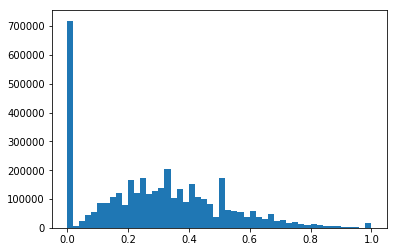

In [21]:
plt.hist(se_gps_data_hour_prev_next[:,1], bins=50, range=(0,1));

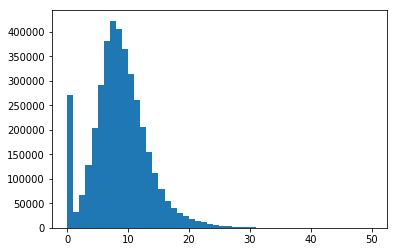

In [22]:
plt.hist(se_gps_data_hour_prev_next[:,4], bins=50, range=(0,50));

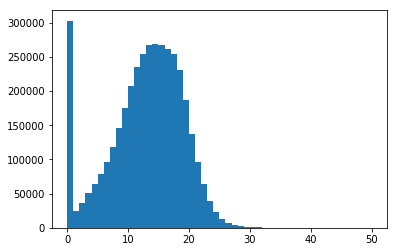

In [23]:
plt.hist(se_gps_data_hour_prev_next[:,13], bins=50, range=(0,50));

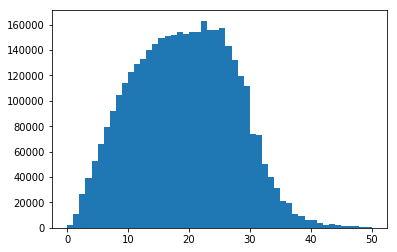

In [24]:
plt.hist(se['speed_mph'], bins=50, range=(0,50));

(0.0, 50.0, 0.0, 30.0)

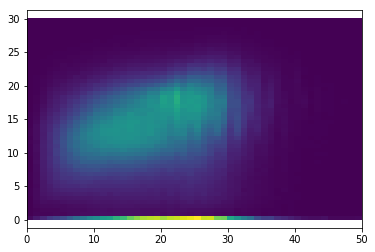

In [25]:
plt.hist2d(se['speed_mph'], se_gps_data_hour_prev_next[:,13], range=[[0,50],[0,30]], bins=[50,50]);
plt.axis('equal')

In [26]:
plt.hist(filtered['speed_mph'], bins=50, range=(3,50));

NameError: name 'filtered' is not defined

In [27]:
def make_valid_mask(freq):

    valid_mask = (se_gps_data_hour_prev_next[:,9] >= freq) & \
    (se['speed_mph'] != np.inf) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,4])) & \
    (~np.isnan(se_gps_data_hour_prev_next[:,10])) & \
    (se_gps_data_hour_prev_next[:,13] != 0)
    
    return valid_mask

In [ ]:
# def do_baselines(valid_mask):
#     (baseline_array_cum, 
#      actual_array_cum, 
#      baseline_median_array_cum, 
#      baseline_pass_count, 
#      pass_fraction, 
#      baseline_median_pass_count, 
#      median_pass_fraction) =  calc_baseline_and_actual(se[int(len(se)*test_fraction):])

#     return (baseline_array_cum, 
#          actual_array_cum, 
#          baseline_median_array_cum, 
#          baseline_pass_count, 
#          pass_fraction, 
#          baseline_median_pass_count, 
#          median_pass_fraction)

# calc_baseline_and_actual

In [ ]:
# 0 slow_fraction
# 1 fast_hmean
# 2 fast_mean
# 3 total_mean
# 4 clipped_hmean
# 5 clipped_mean
# 6 freq_total
# 7 freq_fast
# 8 freq_clipped
# 9 fast_median
# 10 fast_75th percential
# 11 total_median
# 12 total_75th percential
# 13 max

overlaps_dict = {}
overlaps_dict[0] = []
overlaps_dict[1] = [4, 5, 11, 9, 12]
overlaps_dict[2] = [3, 10, 9]
overlaps_dict[3] = [2, 10, 12]
overlaps_dict[4] = [1, 5]
overlaps_dict[5] = [1, 4]
overlaps_dict[6] = [7, 8]
overlaps_dict[7] = [6, 8]
overlaps_dict[8] = [6, 7]
overlaps_dict[9] = [1, 2, 10, 12]
overlaps_dict[10] = [2, 9, 3]
overlaps_dict[11] = [1, 12]
overlaps_dict[12] = [1, 3, 9, 11]
overlaps_dict[13] = []
overlaps_dict[14] = []
overlaps_dict[15] = []


In [28]:
def make_overlap_mask(width = 17):
    overlaps_mask = np.zeros(width)

    overlaps_mask[:] = -1
    
    overlaps_mask[11] = 1 # 11 total_median
    overlaps_mask[4] = 1 # 4 clipped_hmean
    overlaps_mask[3] = 1 # 3 total_mean
    
    while(np.isin([-1], overlaps_mask).any()):
        options = np.where(overlaps_mask < 0)[0]
    #     print(options)
        i = np.random.randint(len(options))
#         print(i)
        overlaps_mask[options[i]] = 1
        overlaps_mask[overlaps_dict[options[i]]] = 0

    return overlaps_mask.astype(bool)
    


In [29]:
def best_overlap_mask(freq, data, columns):
    
#     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
#                                                             'direction_degrees', 
#                                                             "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day']].values))

    df_cors = pd.DataFrame(data=np.hstack((data, se[['speed_mph']].values)),
                        columns=columns)

    cors = df_cors[df_cors['freq_fast'] >= freq].corr()
    
    overlaps_dict = {}

    abs_cor_top_75th = np.percentile(np.abs(cors.values), 75)

    for col_idx, column in enumerate(cors.columns):

        if column == 'true_speed':
            continue

        overlaps_dict[column] = []

        for row_idx, (name, value) in enumerate(cors[column].iteritems()):
            if np.abs(value) > abs_cor_top_75th and column != name:
    #             print(f"{column} -> {name}: {value}")
                overlaps_dict[column].append(row_idx)
        
    overlap_mask = np.empty(len(cors['true_speed']))

    overlap_mask[:] = -1

    for best in cors['true_speed'].abs().sort_values().index[::-1]:

        if(best == "true_speed"):
            continue

        best_idx = cors.columns.get_loc(best)

        if overlap_mask[best_idx] == -1:
            overlap_mask[best_idx] = 1
            overlap_mask[overlaps_dict[best]] = 0


    return overlap_mask[:-1]

In [30]:
train_speeds = se['speed_mph'][:int(len(se)*test_fraction)]

mean_speed = np.mean(train_speeds[np.isfinite(train_speeds)])
print(mean_speed)

23.190210003287937


In [36]:
(baseline_array_cum, 
     actual_array_cum, 
     baseline_median_array_cum, 
     baseline_pass_count, 
     pass_fraction, 
     baseline_median_pass_count, 
     median_pass_fraction) = calc_baseline_and_actual(se[int(len(se)*test_fraction):])

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


In [37]:
def learn(freq, dropout, loss, NN, use_linear = False):
    
    valid_mask = make_valid_mask(freq)
    
#     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
#                                                             'direction_degrees', 
#                                                             "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day'
#                                                            ]].values))

#     overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
#                                     'clipped_hmean','clipped_mean','freq_total',
#                                     'freq_fast','freq_clipped', 
#                                    'fast_median', 'fast_75th percential',
#                                   'total_median', 'total_75th percential', 'max', 
#                                  'real_length', 'direction_degrees', "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day','true_speed'])


    data = se_gps_data_hour_prev_next[:,1:]

    overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                    'clipped_hmean','clipped_mean','freq_total',
                                    'freq_fast','freq_clipped', 
                                   'fast_median', 'fast_75th percential',
                                  'total_median', 'total_75th percential', 'max','std', 
                                    'true_speed'])

    
    # where on the reduced (valid mask) data is the right place to cut so that when it comes back
    # it's exactly test_fraction from the start
    cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
#     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled_baseline, test_target_scaled_baseline, 
#      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

    print(overlaps_mask)
    
    model = create_simple_model(
            (train_data_scaled.shape[1]),
            dropout, NN, use_linear)

    Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"GPS_models/freq_{freq}_mask_{overlaps_mask}_simple_[{'_'.join(list(map(str, NN)))}]_{loss}_{dropout}_{use_linear}.h5",
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
#     model.compile(optimizer="rmsprop", loss="logcosh")
    model.compile(optimizer="rmsprop", loss=loss)
    model.fit(
        train_data_scaled,
        train_target_scaled,
        epochs=100,
        callbacks=callbacks_list,
        batch_size=256,
        validation_data=(test_data_scaled, test_target_scaled),
    )

    test_y_scaled = model.predict(test_data_scaled)

    test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

    test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
    test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

    RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
    MAE = mean_absolute_error(test_target_truth, test_y)
    
    print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
    print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")
    print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")

    print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
    print(f"MAE base: {mean_absolute_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    print(f"MAE base_median: {mean_absolute_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    
    predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

    return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [65]:
def learn_PCA(freq, dropout, loss, NN, use_linear = False):
    
    valid_mask = make_valid_mask(freq)
    
#     data = np.hstack((se_gps_data_hour_prev_next[:,1:], se[['real_length', 
#                                                             'direction_degrees', 
#                                                             "to_centre_dist",
#                                                            'rain',
#                                                            'arrival_hour',
#                                                            'arrival_day'
#                                                            ]].values))


    data = se_gps_data_hour_prev_next[:,1:]

    
    # where on the reduced (valid mask) data is the right place to cut so that when it comes back
    # it's exactly test_fraction from the start
    cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    

    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data(data[valid_mask,:], se[valid_mask]['speed_mph'], cut_point_valid)
    
    pca = PCA(n_components=0.95, svd_solver = 'full')
    
    train_data_scaled = pca.fit_transform(train_data_scaled)
    test_data_scaled = pca.transform(test_data_scaled)
    
    print(f"Using {len(pca.explained_variance_)} PCA components")
    
    model = create_simple_model(
            (train_data_scaled.shape[1]),
            dropout, NN, use_linear)

    Path(f"GPS_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"GPS_models/freq_{freq}_pca_{len(pca.explained_variance_)}_simple_[{'_'.join(list(map(str, NN)))}]_{loss}_{dropout}_{use_linear}.h5",
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
#     model.compile(optimizer="rmsprop", loss="logcosh")
    model.compile(optimizer="rmsprop", loss=loss)
    model.fit(
        train_data_scaled,
        train_target_scaled,
        epochs=100,
        callbacks=callbacks_list,
        batch_size=256,
        validation_data=(test_data_scaled, test_target_scaled),
    )

    test_y_scaled = model.predict(test_data_scaled)

    test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

    test_y[valid_mask[int(len(se)*test_fraction):]] = np.clip(scaler_target.inverse_transform(test_y_scaled), 0, 40)
    
    test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

    RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
    MAE = mean_absolute_error(test_target_truth, test_y)
    
    print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
    print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")
    print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")

    print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
    print(f"MAE base: {mean_absolute_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    print(f"MAE base_median: {mean_absolute_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    
    predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

    return pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum, scaler_target.inverse_transform(test_y_scaled)

In [38]:
def learn_KNN(freq=10, k=5):
    
    valid_mask = make_valid_mask(freq)
    
    data = se_gps_data_hour_prev_next[:,1:]

    overlaps_mask = best_overlap_mask(freq, data, ['slow_fraction', 'fast_hmean', 'fast_mean', 'total_mean',
                                    'clipped_hmean','clipped_mean','freq_total',
                                    'freq_fast','freq_clipped', 
                                   'fast_median', 'fast_75th percential',
                                  'total_median', 'total_75th percential', 'max', 'std', 
                                    'true_speed'])

    
    # where on the reduced (valid mask) data is the right place to cut so that when it comes back
    # it's exactly test_fraction from the start
    cut_point_valid = np.count_nonzero(valid_mask[:int(len(se)*test_fraction)])
    
#     speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237
    
#     (train_data_scaled, test_data_scaled, 
#      train_target_scaled_baseline, test_target_scaled_baseline, 
#      scaler_target_baseline) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], speeds_mph_simple[valid_mask], cut_point_valid)


    (train_data_scaled, test_data_scaled, 
     train_target_scaled, test_target_scaled, 
     scaler_target) = prep_training_data(data[valid_mask,:][:, (overlaps_mask==1)], se[valid_mask]['speed_mph'], cut_point_valid)

    neigh = KNeighborsRegressor(n_neighbors=k, weights="distance")
    neigh.fit(train_data_scaled, train_target_scaled) 

    test_y_scaled = neigh.predict(test_data_scaled)

    test_y = (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]

    test_y[valid_mask[int(len(se)*test_fraction):]] = scaler_target.inverse_transform(test_y_scaled)
    
    test_target_truth = se['speed_mph'][int(len(se)*test_fraction):]
    
    test_target_truth[~np.isfinite(test_target_truth)] = mean_speed

    RMSE = np.sqrt(mean_squared_error(test_target_truth, test_y))
    
    MAE = mean_absolute_error(test_target_truth, test_y)
    
    print(f"RMSE pred: {np.sqrt(mean_squared_error(test_target_truth, test_y))}")
    print(f"RMSE base: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")
    print(f"RMSE base_median: {np.sqrt(mean_squared_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):]))}")

    print(f"MAE pred: {mean_absolute_error(test_target_truth, test_y)}")
    print(f"MAE base: {mean_absolute_error(test_target_truth, (se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")
    print(f"MAE base_median: {mean_absolute_error(test_target_truth, (se['real_length'] / se['median_durations_by_segment_code_and_hour_and_day'] * 2.237)[int(len(se)*test_fraction):])}")

    
    predict_array_NN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[int(len(se)*test_fraction):], test_y, baseline_array_cum, actual_array_cum)

    return overlaps_mask, pass_fraction, RMSE, MAE, test_y, predict_array_NN_cum

In [ ]:
_, _, _, _, test_y, predict_array_KNN_cum = learn_KNN(10, 5)

In [41]:
_, _, _, _, test_y, predict_array_NN_cum = learn(10, 0.0, "logcosh", [64,32,12], False)

# Draw real vs streight length for messages - Yes
# Try using straight lengths for the messages instead - Bad
# Try using a linear instead of tanh activation for the last layer - Worse
# Try predicting the mean and then still testing against true, for various networks
# Try to find one bus route where this works really well

[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                396       
_______________________

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -27.36% improvment on baseline
Approximately 28.44% are in 10%


In [66]:
_, _, _, test_y, predict_array_NN_PCA_cum, wraw_prediction = learn_PCA(12, 0.0, "logcosh", [32,32,12], False)


Using 5 PCA components
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 5)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                192       
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 12)                396       
_________________________________________________________________
dropout_30 (Dropout)         (None, 12)              

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


Approximately -26.44% improvment on baseline
Approximately 28.80% are in 10%


In [ ]:
with open("GPS_run_3.csv", "a+") as f: 
    f.write("freq_threshold,dropout,loss,overlap_mask,NN,use_linear,pass_fraction,RMSE,MAE\n")
    for runs in range(5):
        for dropout in [0,0.2,0.5]:
            for loss in ['logcosh', 'mean_absolute_error', 'mean_squared_error']:
                for NN in [[64,32,12]]: #[[32,12,6], [64,32,12], [128,64,32,32,12]]:
                    for freq in [3,10,15,25]:
                        for use_linear in [True, False]:
                    
                            overlaps_mask, pass_fraction, RMSE, MAE, test_y = learn(freq, dropout, loss, NN, use_linear)
                            f.write(f"{freq},{dropout},{loss},{'_'.join(list(map(str,overlaps_mask)))},{'_'.join(list(map(str,NN)))},{use_linear},{pass_fraction},{RMSE},{MAE}\n")
                            f.flush()


..............................................................................
..............................................................................
..............................................................................
..............................................................................

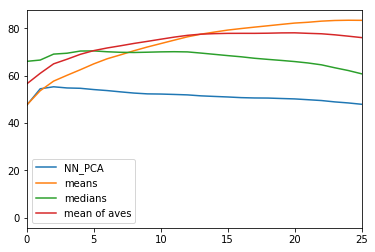

In [57]:
plt.plot(make_accuracy_matrix_minutes(predict_array_NN_PCA_cum, actual_array_cum)[0][1,:], label="NN_PCA")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][1,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][1,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][1,:], label="mean of aves")
plt.xlim(0,25)
plt.legend()
plt.show()

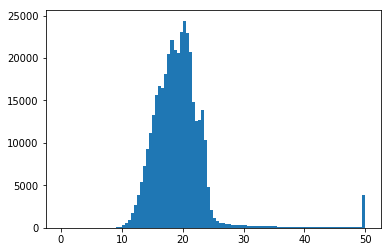

In [68]:
plt.hist(np.clip(wraw_prediction, 0, 50), bins=100, range=(0,50));

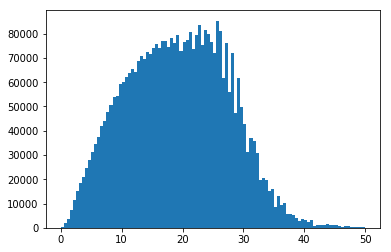

In [69]:
plt.hist(se['speed_mph'], bins=100, range=(0,50));

In [ ]:
plt.hist(test_y, bins=100, label="pred", density=True, range=(-10,100));
plt.hist(se['speed_mph'][int(len(se)*test_fraction):], bins=100, label="truth", alpha=0.5, density=True, range=(-10,100));
plt.legend()

In [ ]:
speeds_mph_simple = se['real_length'] / se['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

se_min = se[['speed_mph', 'publicName', 'to_centre_dist', 'real_length', 'mean_durations_by_segment_code_and_hour_and_day']][int(len(se)*test_fraction):].copy()

se_min['baseline_speed'] = se_min['real_length'] / se_min['mean_durations_by_segment_code_and_hour_and_day'] * 2.237

se_min['test_y'] = test_y

routes = []
pred_MSE = []
pred_RMSE = []
base_MSE = []
base_RMSE = []
freq = []
mean_dist = []

for route_name, route in se_min.groupby('publicName'):
    
    if route_name in schools:
        continue
        
    routes.append(route_name)
    pred_MSE.append(mean_absolute_error(route['speed_mph'], route['test_y']))
    pred_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['test_y'])))
    base_MSE.append(mean_absolute_error(route['speed_mph'], route['baseline_speed']))
    base_RMSE.append(np.sqrt(mean_squared_error(route['speed_mph'], route['baseline_speed'])))
    freq.append(len(route))
    
results = pd.DataFrame(index=routes)
results['pred_MSE'] = pred_MSE
results['base_MSE'] = base_MSE
results['pred_RMSE'] = pred_RMSE
results['base_RMSE'] = base_RMSE
results['freq'] = freq

In [ ]:
results.sort_values('pred_RMSE')

In [ ]:
schools = ['46', '50', '60', '81', '85', '86', '87', '87A', '88', '111']

In [ ]:
np.count_nonzero(se['publicName'].isin(schools))

In [ ]:
# test_target_truth = se['speed_mph'][int(len(se[valid_mask])*test_fraction):]

test_target_truth = scaler_target.inverse_transform(test_target_scaled).squeeze()

print(np.sqrt(mean_squared_error(test_target_truth, test_y)))

plt.hist2d(test_target_truth, test_y.squeeze(), range=[[0,30],[0,30]], bins=[30,30])
plt.xlabel("true target (mph)")
plt.ylabel("prediction target (mph)")
plt.ylim(-5,35)
plt.axis('equal')

In [ ]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(se[valid_mask][int(len(se[valid_mask])*test_fraction):], test_y.squeeze(), baseline_array_cum, actual_array_cum)
  

In [32]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))
    
    print("")

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [33]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [34]:
def calc_baseline_and_actual(data):
    
    se_min = data.copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    baseline_median_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_median_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")
    baseline_median_index = se_min.columns.get_loc("median_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])
        baseline_median_array[run.index,:] = create_triangle(run.iloc[:, baseline_median_index])
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    baseline_median_array_cum = np.cumsum(baseline_median_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    baseline_median_pass_count = np.count_nonzero((baseline_median_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_median_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    median_pass_fraction = baseline_median_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_median_array_cum, baseline_pass_count, pass_fraction, baseline_median_pass_count, median_pass_fraction


In [35]:
def calc_prediction_cum_journeys(data, speeds_mph, baseline_array_cum, actual_array_cum):
    
    se_min = data.copy()
      
    se_min['prediction'] = se_min['real_length'] / speeds_mph * 2.237
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])
     
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [ ]:
a = pd.DataFrame(data=[[1,2],[3,4],[5,6]], columns=['a','b'])

In [ ]:
a

In [ ]:
b = a[1:].copy()

In [ ]:
b

In [ ]:
b['c'] = a['a']

In [ ]:
b